In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
            device = '/gpu:9'
    except RuntimeError as e:
        print(e)

print("device", device)

2024-08-01 21:29:16.515915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 21:29:16.588136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 21:29:16.662095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 21:29:16.692046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 21:29:16.762645: I tensorflow/core/platform/cpu_feature_guar

device /gpu:9


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import h5py 



In [3]:


# Load HDF5 data
h5_filename = '/home/da886/ElectronCountingProject/500KImagesForOverfitting_smaller_negative paddings.h5'
with h5py.File(h5_filename, 'r') as f:
    images = np.array(f['images'])
    # bounding_boxes = np.array(f['bounding_boxes'])
    centers = np.array(f['centers_training'])


#####For Bounding boxes 
# # Step 1: Calculate the maximum value across the entire dataset
# global_max_image_value = np.max(images)
# global_max_box_value = np.max(bounding_boxes)

# # Step 2: Normalize each image using the global maximum value
# normalized_images = images / global_max_image_value
# normalized_bounding_boxes = bounding_boxes / global_max_box_value

global_max_image_value = np.max(images)
global_max_center_value = np.max(centers)
normalized_images = images / global_max_image_value
normalized_centers = centers / global_max_center_value

In [4]:
normalized_images = np.array(normalized_images)
normalized_centers= np.array(normalized_centers[:, :, 1:])
normalized_centers =tf.expand_dims(normalized_centers,axis=1)


2024-08-01 21:31:40.608840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 9, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:cf:00.0, compute capability: 8.0


In [5]:
normalized_centers

<tf.Tensor: shape=(500000, 1, 12, 2), dtype=float32, numpy=
array([[[[ 0.10236221,  0.13385826],
         [ 0.46456692,  0.71653545],
         [ 0.79527557,  0.16535433],
         ...,
         [-0.01574803, -0.01574803],
         [-0.01574803, -0.01574803],
         [-0.01574803, -0.01574803]]],


       [[[ 0.11811024,  0.63779527],
         [ 0.16535433,  0.9527559 ],
         [ 0.22834645,  0.1496063 ],
         ...,
         [-0.01574803, -0.01574803],
         [-0.01574803, -0.01574803],
         [-0.01574803, -0.01574803]]],


       [[[ 0.96850395,  0.13385826],
         [ 0.6062992 ,  0.68503934],
         [ 0.10236221,  0.7322835 ],
         ...,
         [-0.01574803, -0.01574803],
         [-0.01574803, -0.01574803],
         [-0.01574803, -0.01574803]]],


       ...,


       [[[ 0.30708662,  0.8425197 ],
         [ 0.03937008,  0.496063  ],
         [-0.01574803, -0.01574803],
         ...,
         [-0.01574803, -0.01574803],
         [-0.01574803, -0.01574803],
       

In [5]:

split_idx = int(0.8 * len(normalized_images))
train_images, val_images = normalized_images[:split_idx], normalized_images[split_idx:]
train_boxes, val_boxes = normalized_centers[:split_idx], normalized_centers[split_idx:]
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_boxes))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_boxes))
batch_size = 250

# Shuffle each dataset separately
train_dataset = train_dataset.shuffle(buffer_size=500,reshuffle_each_iteration= True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=500).batch(batch_size)

In [7]:
train_images.shape

(450000, 64, 64)

(array([[64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [63.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [63.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [63.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [62.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  

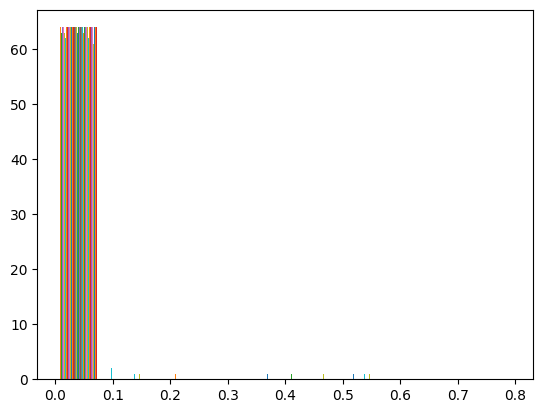

In [7]:
y = np.random.randint(0, len(normalized_images))
plt.hist(normalized_images[y].squeeze())

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

input_shape = (64, 64,1)
num_classes = 12
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x_input)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x) 


x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dense(32,activation='relu')(x)

x_prob = layers.Dense(num_classes,activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes,1), name='x_probabilities_reshape')(x_prob)
# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input,[x_prob_reshape,x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) 



In [8]:
model = tf.keras.Model(x_input,
           outputs=x_midpoints_reshape)

In [9]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=optimizer, metrics=['accuracy'])

In [10]:
history = model.fit(train_dataset,
             validation_data=val_dataset,
             batch_size=batch_size,
             epochs=100)

Epoch 1/100


I0000 00:00:1722548214.956641 1911492 service.cc:146] XLA service 0x7ef9a8016630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722548214.956836 1911492 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-01 21:36:55.397976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 21:36:56.686546: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-01 21:36:57.661908: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility pa

   1/1600 ━━━━━━━━━━━━━━━━━━━━ 42:10:58 95s/step - accuracy: 0.5707 - loss: 0.1568

I0000 00:00:1722548277.977423 1911492 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 287s 120ms/step - accuracy: 0.4230 - loss: 1.0759 - val_accuracy: 0.5288 - val_loss: 0.0757
Epoch 2/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 182s 114ms/step - accuracy: 0.4119 - loss: 0.0760 - val_accuracy: 0.3528 - val_loss: 0.0757
Epoch 3/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 183s 114ms/step - accuracy: 0.4167 - loss: 0.0760 - val_accuracy: 0.4378 - val_loss: 0.0757
Epoch 4/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 183s 114ms/step - accuracy: 0.4565 - loss: 0.0760 - val_accuracy: 0.5871 - val_loss: 0.0757
Epoch 5/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 185s 115ms/step - accuracy: 0.5782 - loss: 0.0760 - val_accuracy: 0.5789 - val_loss: 0.0757
Epoch 6/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 183s 115ms/step - accuracy: 0.5808 - loss: 0.0760 - val_accuracy: 0.5118 - val_loss: 0.0758
Epoch 7/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 183s 114ms/step - accuracy: 0.5791 - loss: 0.0760 - val_accuracy: 0.4532 - val_loss: 0.0757
Epoch 8/100
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 183s 114ms/step - accura

In [11]:
model.save("addeddense_sigmoidlast.keras")

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_boxes))
train_dataset = train_dataset.batch(500)

inputs,targets = next(iter(train_dataset))
# inputs,targets = next(iter(test_dataset))
output =model.predict(inputs)

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step


In [13]:
output[1],targets[1]

(array([[[4.6970272e-01, 5.2110720e-01, 5.0765902e-01, 5.5596435e-01],
         [4.4477227e-01, 9.9854089e-02, 4.8334906e-01, 1.1297349e-01],
         [3.9510608e-01, 2.1971077e-01, 4.2923024e-01, 2.4661343e-01],
         [3.5245419e-01, 8.4105217e-01, 3.8758525e-01, 8.6175227e-01],
         [8.2565486e-01, 2.3828153e-01, 8.4739739e-01, 2.6495022e-01],
         [4.4701239e-01, 8.5929942e-01, 4.8605704e-01, 8.7861192e-01],
         [1.5950543e-01, 2.0630080e-01, 1.7860192e-01, 2.2709280e-01],
         [3.0957844e-02, 3.3569723e-02, 3.4387540e-02, 3.6496188e-02],
         [6.2855217e-04, 1.5608283e-03, 6.2188372e-04, 1.4953756e-03],
         [4.5723442e-07, 5.9011486e-06, 3.4284034e-07, 4.8631473e-06],
         [6.1706109e-22, 1.5095975e-21, 2.1517591e-21, 6.5171690e-21],
         [1.0318870e-19, 1.6494774e-21, 2.2127436e-19, 1.1367855e-22]]],
       dtype=float32),
 <tf.Tensor: shape=(1, 12, 4), dtype=float64, numpy=
 array([[[ 0.34883721,  0.58139535,  0.37984496,  0.6124031 ],
       

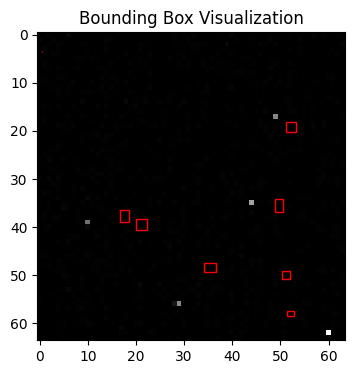

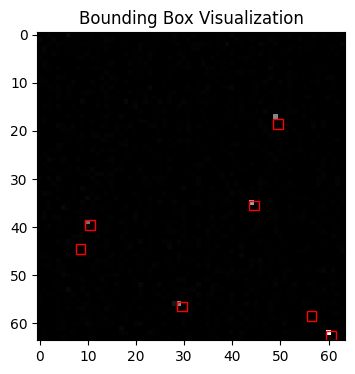

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_bounding_boxes(image, bounding_boxes):
    """
    Visualizes bounding boxes on an image.

    Parameters:
    - image: A 3D tensor representing the image.
    - bounding_boxes: A 2D tensor representing the bounding box coordinates (x_min, y_min, x_max, y_max).

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    bounding_boxes_np = bounding_boxes

    # print("Bounding Boxes Shape:", bounding_boxes_np.shape)
    # print("Bounding Boxes:", bounding_boxes_np)

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes
    for box in bounding_boxes_np:
        x_min, y_min, x_max, y_max = box[:4]
        rect = plt.Rectangle((x_min * global_max_box_value, y_min * global_max_box_value), (x_max - x_min) * global_max_box_value, (y_max - y_min) * global_max_box_value, 
                             linewidth=1, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)

    plt.show()

# Example usage
t = np.random.randint(0,500)
# t=4
image = tf.convert_to_tensor(inputs[t])
predicted_bounding_boxes = output[t].squeeze() # Using predicted bounding boxes
ground_truth_bounding_boxes = targets[t].numpy().squeeze()   # Using ground truth bounding boxes

visualize_bounding_boxes(image, predicted_bounding_boxes)
visualize_bounding_boxes(image, ground_truth_bounding_boxes)
